In [38]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Progbar
import os
import cv2

# rediseñar tamaño a 64 x 64 

In [39]:
# Directorio donde se encuentran las imágenes originales de 200x200
original_dir = "./simpsons_dataset/cropped"

# Directorio donde guardarás las imágenes redimensionadas de 64x64
resized_dir = "./simpsons_dataset_resized/cropped"

In [ ]:
# # Asegúrate de que el directorio de salida exista
# os.makedirs(resized_dir, exist_ok=True)

# # Lista de archivos en el directorio original
# files = os.listdir(original_dir)

# # Itera a través de los archivos y redimensiona las imágenes
# for file in files:
#     if file.endswith(".png"):
#         image = cv2.imread(os.path.join(original_dir, file))
#         resized_image = cv2.resize(image, (64, 64))
#         cv2.imwrite(os.path.join(resized_dir, file), resized_image)

# print("Imágenes redimensionadas y guardadas en el directorio:", resized_dir)

In [40]:
# Configura la ruta a tus datos
data_dir = "./simpsons_dataset_resized/"

# Asegúrate de que las imágenes sean del mismo tamaño
img_height = 64
img_width = 64
batch_size = 150

In [41]:
# Crea un generador de datos
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # validation_split=0.2
)


In [42]:
# Carga las imágenes desde el directorio
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='input',  # Utilizaremos las imágenes originales como objetivo
    subset='training'
)

Found 9877 images belonging to 1 classes.


In [43]:
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='input',
    subset='validation'
)


Found 0 images belonging to 1 classes.


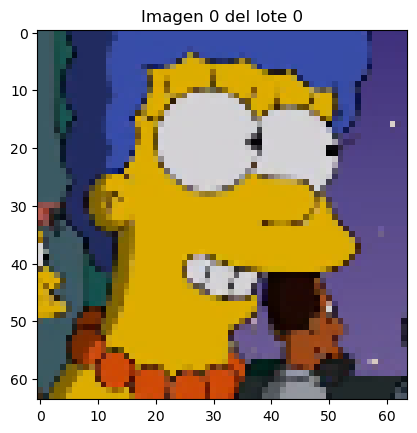

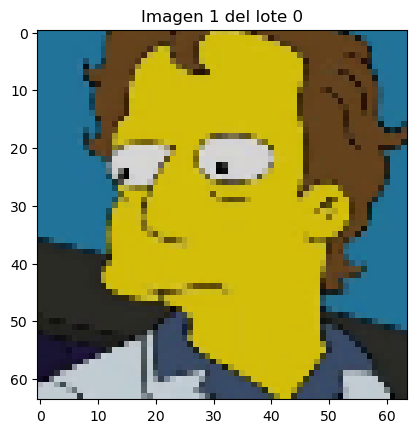

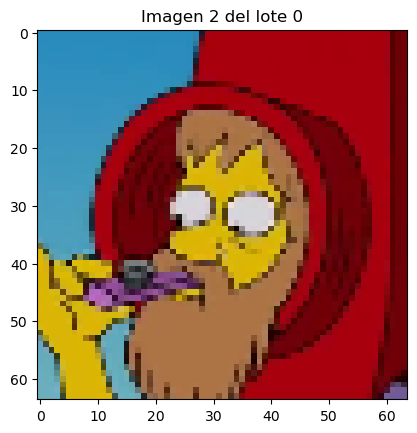

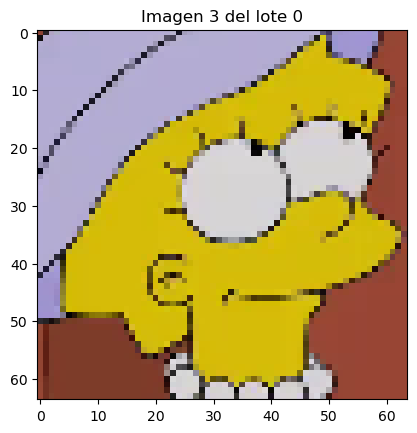

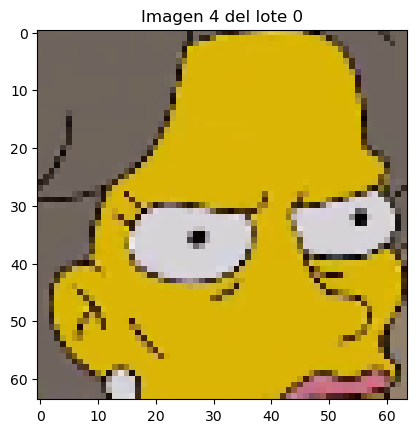

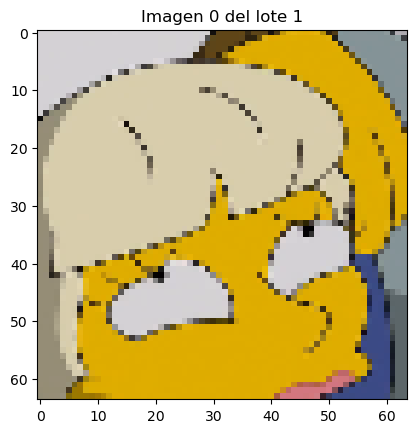

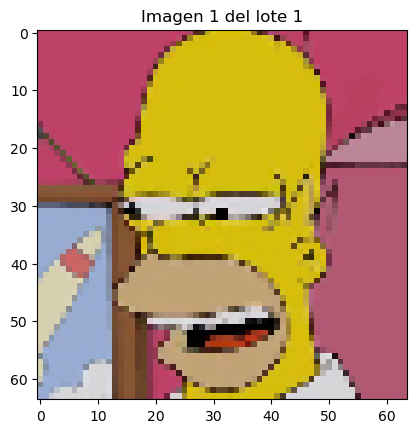

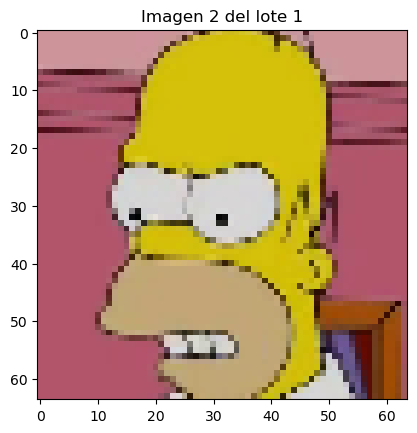

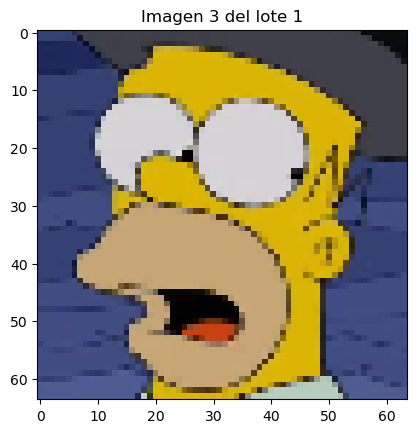

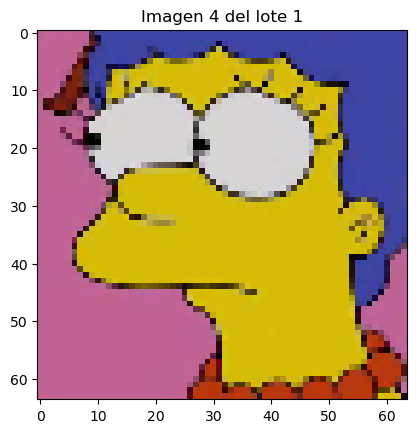

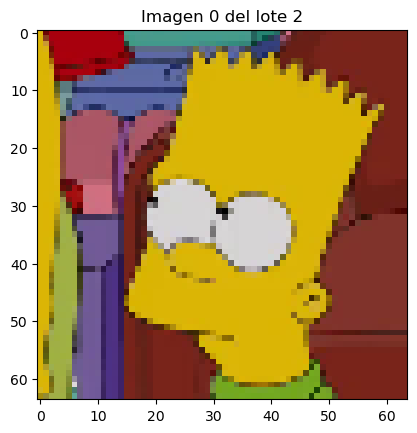

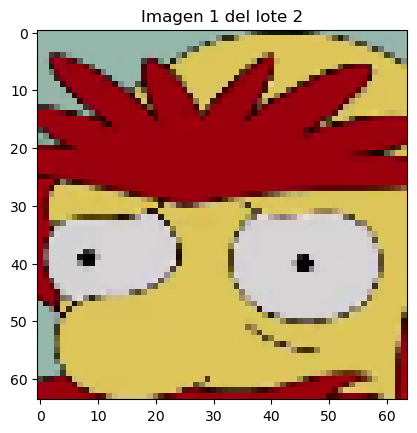

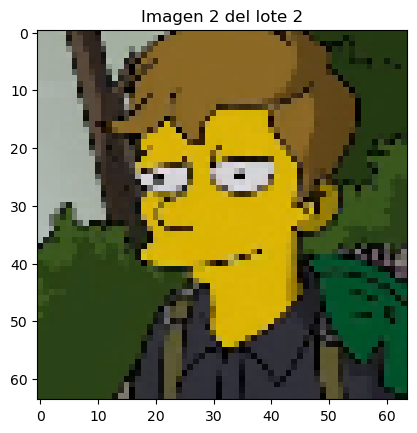

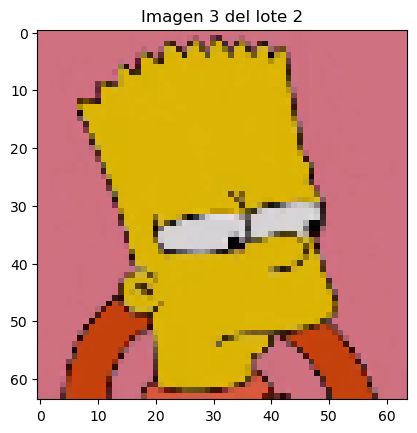

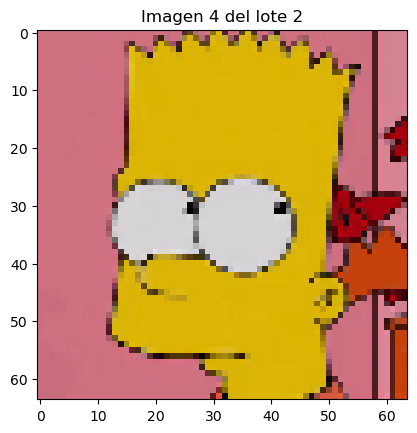

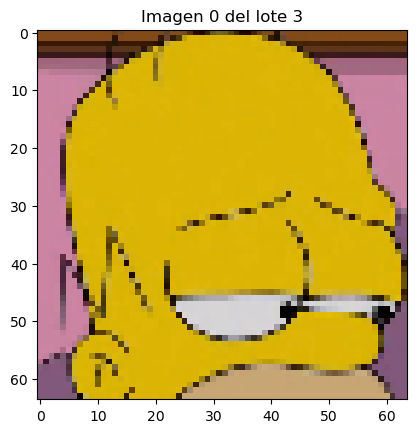

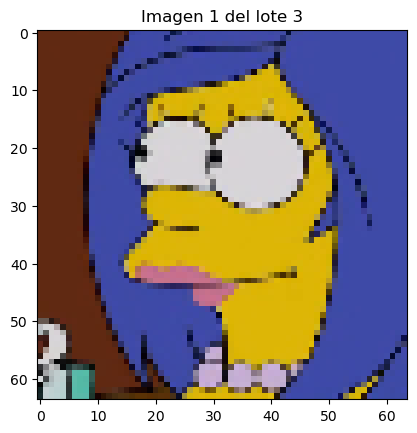

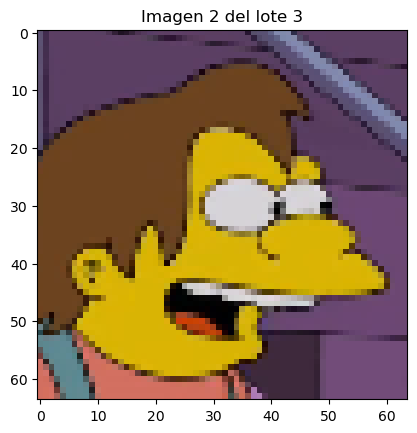

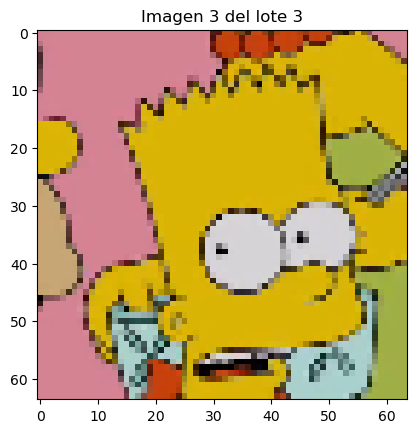

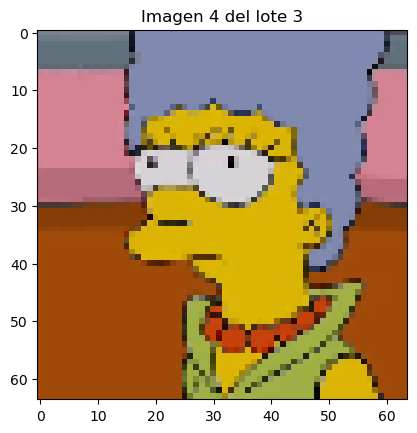

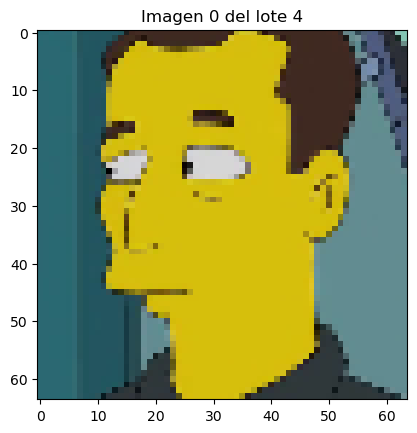

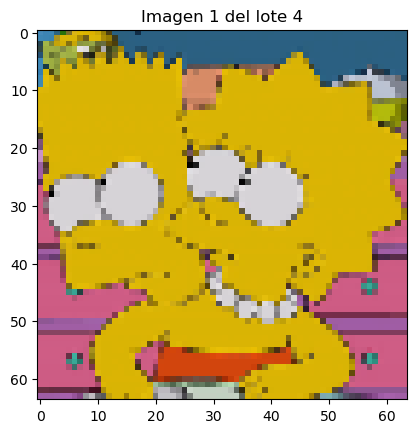

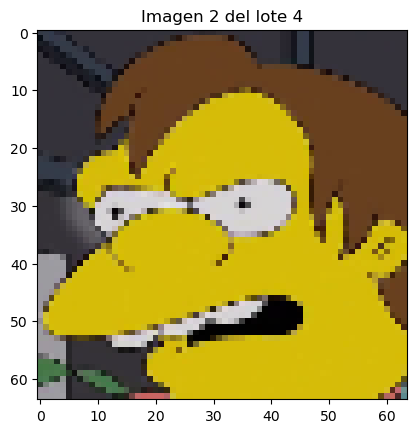

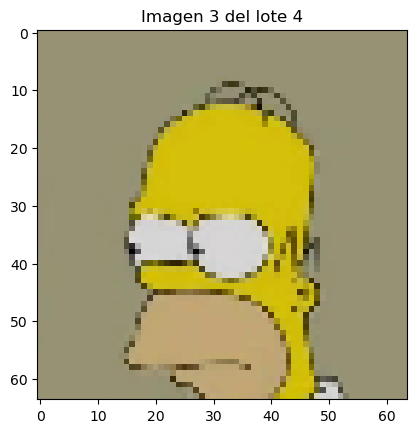

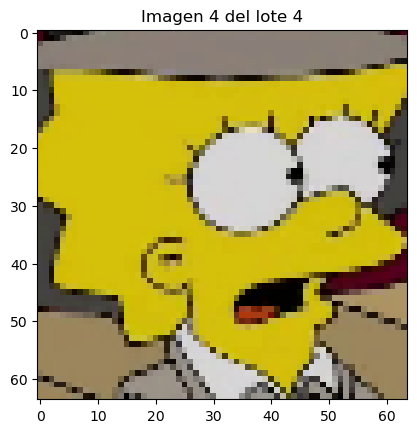

In [7]:
# Itera a través de los primeros 5 lotes de imágenes
for i in range(5):
    batch = next(train_generator)
    images = batch[0]  # El primer elemento del lote es un arreglo de imágenes
    labels = batch[1]  # El segundo elemento del lote son las etiquetas (en este caso, las propias imágenes)

    for j in range(5):
        plt.imshow(images[j])  # Muestra la imagen
        plt.title(f"Imagen {j} del lote {i}")
        plt.show()

# Construir el generador y el discriminador

In [52]:
def build_generator_unet():
    inputs = keras.Input(shape=(img_height, img_width, 3))

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 64)
        downsample(128, 4),  # (batch_size, 32, 32, 128)
        downsample(256, 4),  # (batch_size, 16, 16, 256)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 64)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                 strides=2,
                                 padding='same',
                                 kernel_initializer=initializer,
                                 activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)



def downsample(filters, batch_norm=True):
    initializer = keras.initializers.RandomNormal(0.0, 0.02)
    
    result = keras.Sequential()
    result.add(keras.layers.Conv2D(filters, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=not batch_norm))
    
    if batch_norm:
        result.add(keras.layers.BatchNormalization())
    
    result.add(keras.layers.LeakyReLU())
    
    return result

def upsample(filters, batch_norm=True):
    initializer = keras.initializers.RandomNormal(0.0, 0.02)
    
    result = keras.Sequential()
    result.add(keras.layers.Conv2DTranspose(filters, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=not batch_norm))
    
    if batch_norm:
        result.add(keras.layers.BatchNormalization())
    
    result.add(keras.layers.ReLU())
    
    return result

def build_discriminator_patchgan():
    initializer = tf.random_normal_initializer(0., 0.02)

    # Las imágenes de entrada y objetivo se concatenan a nivel de canal
    inp = layers.Input(shape=[img_height, img_width, 3], name='input_image')
    tar = layers.Input(shape=[img_height, img_width, 3], name='target_image')

    x = layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return keras.Model(inputs=[inp, tar], outputs=last)





## Funciones de perdidas

In [53]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

LAMBDA = 100

def generator_loss(discriminator_fake_output, generated_output, target):
    gan_loss = cross_entropy(tf.ones_like(discriminator_fake_output), discriminator_fake_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - generated_output))

    total_gen_loss = gan_loss + LAMBDA * l1_loss

    return total_gen_loss


def discriminator_loss(discriminator_real_output, discriminator_fake_output):
    real_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(discriminator_real_output), discriminator_real_output)
    fake_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(discriminator_fake_output), discriminator_fake_output)
    return real_loss + fake_loss



## Entrenamiento

In [54]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(input_image, training=True)

        discriminator_real_output = discriminator([input_image, target], training=True)
        discriminator_fake_output = discriminator([input_image, generated_image], training=True)

        gen_loss = generator_loss(discriminator_fake_output, generated_image, target)
        disc_loss = discriminator_loss(discriminator_real_output, discriminator_fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [55]:
def train(dataset, epochs):
    steps_per_epoch = dataset.samples // dataset.batch_size  # Calcula el número de lotes
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        progbar = Progbar(target=steps_per_epoch)  # Inicializa la barra de progreso
        for i in range(steps_per_epoch):  # Utiliza steps_per_epoch en lugar de iterar a través de dataset
            image_batch = next(dataset)
            gen_loss, disc_loss = train_step(*image_batch)  # Asegúrate de que train_step devuelva las pérdidas
            values = [('gen_loss', float(gen_loss)), ('disc_loss', float(disc_loss))]
            progbar.update(i+1, values=values)  # Actualiza la barra de progreso

# Define el número de épocas y entrena el modelo
num_epochs = 100
train(train_generator, num_epochs)



Epoch 1/100


ValueError: in user code:

    File "C:\Users\PARK JONGHYUN\AppData\Local\Temp\ipykernel_15620\560607553.py", line 10, in train_step  *
        discriminator_fake_output = discriminator([input_image, generated_image], training=True)
    File "C:\Users\PARK JONGHYUN\AppData\Roaming\Python\Python39\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\PARK JONGHYUN\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "model_7" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(150, 32, 32, 3)


In [37]:
def generate_and_save_images(model, epoch, test_input):
    # Asegúrate de que el modelo esté en modo de evaluación
    predictions = model(test_input, training=False)

    # Escala las imágenes entre 0 y 1
    predictions = (predictions + 1) / 2.0

    # Muestra las imágenes
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    # Guarda las imágenes
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Genera ruido aleatorio
test_input = tf.random.normal([16, 100])

# Genera imágenes y guárdalas
generate_and_save_images(generator, num_epochs, test_input)


ValueError: Input 0 of layer "model_6" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(16, 100)

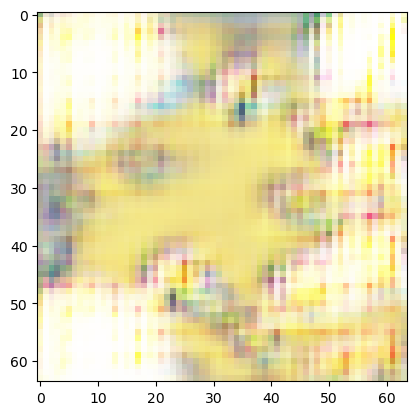

In [ ]:
def generate_new_image(generator):
    # Genera ruido aleatorio
    noise = tf.random.normal([1, 100])

    # Usa el generador para crear una nueva imagen
    generated_image = generator(noise, training=False)

    # Procesa la imagen generada
    generated_image = (generated_image + 1) / 2  # Mapea el rango de píxeles a [0, 1]
    generated_image = np.clip(generated_image, 0, 1)
    generated_image = generated_image[0]  # Elimina la dimensión de lote
    generated_image = np.uint8(generated_image * 255)  # Mapea el rango de píxeles a [0, 255]

    return generated_image

# Genera una nueva imagen
new_image = generate_new_image(generator)

# Muestra la nueva imagen
plt.imshow(new_image)
plt.show()
